In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time

In [59]:
%matplotlib inline

In [60]:
# Load data from CSV files
X_train_df = pd.read_csv('time-series_data/X_train.csv')
X_test_df = pd.read_csv('time-series_data/X_test.csv')
X_val_df = pd.read_csv('time-series_data/X_val.csv')
Y_train_df = pd.read_csv('time-series_data/Y_train.csv')
Y_test_df = pd.read_csv('time-series_data/Y_test.csv')
Y_val_df = pd.read_csv('time-series_data/Y_val.csv')

# Select rows 461 to 480
# X_train_df = X_train_df.iloc[460:480]
X_test_df = X_test_df.iloc[460:480]
# X_val_df = X_val_df.iloc[460:480]
# Y_train_df = Y_train_df.iloc[460:480]
Y_test_df = Y_test_df.iloc[460:480]
# Y_val_df = Y_val_df.iloc[460:480]

# Convert DataFrames to NumPy arrays
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
X_val = X_val_df.to_numpy()
Y_train = Y_train_df.to_numpy()
Y_test = Y_test_df.to_numpy()
Y_val = Y_val_df.to_numpy()

print('X_train.shape',X_train.shape)
print('Y_train.shape',Y_train.shape)
print('X_test.shape',X_test.shape)
print('Y_test.shape',Y_test.shape)
print('X_val.shape',X_val.shape)
print('Y_val.shape',Y_val.shape)

X_train.shape (9387, 331)
Y_train.shape (9387, 331)
X_test.shape (20, 331)
Y_test.shape (20, 331)
X_val.shape (2347, 331)
Y_val.shape (2347, 331)


In [61]:
# Add noise function
def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=0.1, size=data.shape)
    return np.clip(noisy_data, 0., 1.)

# Add noise to the data
X_train_noisy = add_noise(X_train)
X_val_noisy = add_noise(X_val)
X_test_noisy = add_noise(X_test)

In [63]:
# Defining the autoencoder model
input_shape = X_train.shape[1]

input_layer = tf.keras.layers.Input(shape=(input_shape,))
encode = tf.keras.layers.Dense(128, activation='relu')(input_layer)
encode = tf.keras.layers.Dense(3, activation='relu')(encode)

decode = tf.keras.layers.Dense(128, activation='relu')(encode)
decode = tf.keras.layers.Dense(input_shape, activation='sigmoid')(decode)

autoencoder = tf.keras.models.Model(input_layer, decode)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
# Calculate hyperparameters
num_layers = len(autoencoder.layers)
num_neurons = [layer.units for layer in autoencoder.layers if isinstance(layer, tf.keras.layers.Dense)]
learning_rate = autoencoder.optimizer.learning_rate.numpy()
activation_functions = [layer.activation.__name__ for layer in autoencoder.layers if hasattr(layer, 'activation')]

In [65]:
# Train the autoencoder and calculate training time
start_time = time.time()
history = autoencoder.fit(X_train_noisy, X_train,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_val_noisy, X_val))
training_time = time.time() - start_time

Epoch 1/100
294/294 [==============================] - 2s 3ms/step - loss: 0.0184 - val_loss: 0.0100
Epoch 2/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 3/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 4/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 6/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 7/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 9/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 10/100
294/294 [==============================] - 0s 2ms/step - loss: 0.0033 - val_lo

In [68]:
# Evaluate the autoencoder
test_loss = autoencoder.evaluate(X_test_noisy, X_test)
print("Test Loss:", test_loss)

1/1 [==============================] - 0s 19ms/step - loss: 0.0044
Test Loss: 0.004405288491398096


In [70]:
# Calculate accuracy
decoded_data = autoencoder.predict(X_test_noisy)
reconstruction_accuracy = np.mean(np.abs(X_test - decoded_data))
print("Reconstruction Accuracy: ",reconstruction_accuracy )

1/1 [==============================] - 0s 17ms/step
Reconstruction Accuracy:  0.05396846286351067


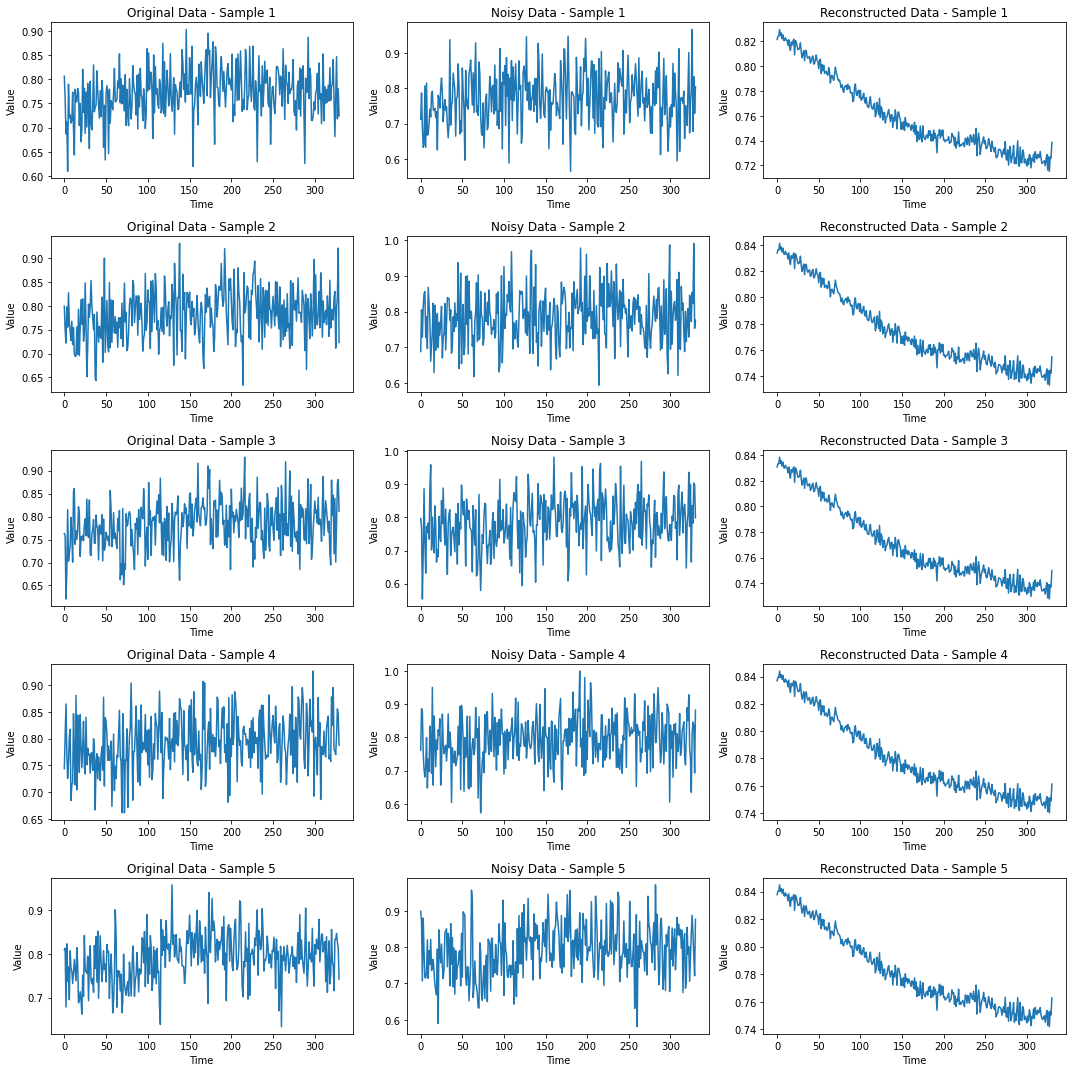

In [71]:
# plot the visualization for 5 samples of data
plt.figure(figsize=(15, 15))
# Plot original data with labels
for i in range(5):
    plt.subplot(5, 3, i*3 + 1)
    plt.plot(X_test[i, :-1])
    plt.title(f'Original Data - Sample {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')

# Plot noisy data
for i in range(5):
    plt.subplot(5, 3, i*3 + 2)
    plt.plot(X_test_noisy[i])
    plt.title(f'Noisy Data - Sample {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')

# Plot reconstructed data
for i in range(5):
    plt.subplot(5, 3, i*3 + 3)
    plt.plot(decoded_data[i])
    plt.title(f'Reconstructed Data - Sample {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


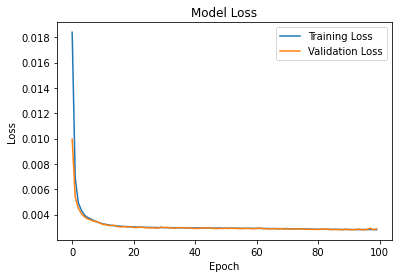

In [72]:
# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
print("Hyperparameters:")
print("Number of layers:", num_layers)
print("Number of neurons in each layer:", num_neurons)
print("Learning rate:", learning_rate)
print("Batch size:", batch_size)
print("Activation functions:", activation_functions)

print("Performance Evaluation:")
print("Training Time:", training_time, "seconds")
print("Test Loss:", test_loss)
print("Reconstruction Accuracy:", reconstruction_accuracy)

Hyperparameters:
Number of layers: 5
Number of neurons in each layer: [128, 3, 128, 331]
Learning rate: 0.001
Batch size: 32
Activation functions: ['relu', 'relu', 'relu', 'sigmoid']
Performance Evaluation:
Training Time: 48.87053728103638 seconds
Test Loss: 0.004405288491398096
Reconstruction Accuracy: 0.05396846286351067
